Social Media Analytics

Topic Modeling Using Twitter and LDA



In [2]:
import tweepy
import csv
import pandas as pd
import re
import collections
import numpy as np
import emoji
import nltk
import time
import itertools
import string
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import gensim
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(99)
warnings.filterwarnings("ignore")
nltk.download('words')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
words = set(nltk.corpus.words.words())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\plaba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\plaba\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### Twitter Data Authorization

In [3]:
api_key = "TK6nkJJ4odiXzsvhxBokjLmti"
api_secret = "VZhRYHpbejsgj953Lm7ThXsGIiNDpsmwSGWPgsrK3Q2NSUDBs0"
access_token = "1351944589931269120-GqB0owKLGw6t9MH7rGlhu5PVdvMjrh"
access_secret = "g3cVCn8uiXTnUepxakisgDZ1NvgoZBbdCuahUOAKgYhOd"

In [4]:
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

### Data collection

In [5]:
user_ids = ['washingtonpost']
no_of_tweets = 2000
tweets = []
likes = []
time = []

In [6]:
for user_id in user_ids:
    for i in tweepy.Cursor(api.user_timeline, id=user_id, tweet_mode="extended").items(no_of_tweets):
        tweets.append(i.full_text)
        likes.append(i.favorite_count)    
        time.append(i.created_at)

In [7]:
new_tweets_df = pd.DataFrame({'tweets':tweets, 'likes':likes, 'time':time})

In [8]:
new_tweets_df

,tweets,likes,time
0,Ridley Scott and the grand tradition of big-na...,17,2021-11-17 22:47:21
1,Pentagon warns National Guard troops could be ...,115,2021-11-17 22:32:13
2,Analysis: Democrats face a 2022 superstorm htt...,67,2021-11-17 22:20:57
3,Analysis: A plurality of Republicans think the...,51,2021-11-17 22:06:01
4,Review: “The Power of the Dog” belongs to Bene...,90,2021-11-17 21:51:32
...,...,...,...
1995,"American canceled about 338 flights Monday, so...",63,2021-11-01 18:56:49
1996,Supreme Court appears willing to let abortion ...,148,2021-11-01 18:51:25
1997,Thousands were gathered Sunday for Shanghai Di...,79,2021-11-01 18:42:28
1998,"RT @zachjourno: MANCHIN: ""It is obvious 'compr...",0,2021-11-01 18:37:15


### EDA

In [13]:
def clean_text(text):
    ps = PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [14]:
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(new_tweets_df['tweets'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

2000 Number of tweets has 7631 words


#### Examine the full vocabulary of my tweet corpus:

In [15]:
# full vocabulary of tweets with corpus 
all_words = [word for tokens in new_tweets_df['tweets'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in new_tweets_df['tweets']]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

294956 words total, with a vocabulary size of 101
Max tweet length is 304


#### Examine the length of each tweet with a countplot using seaborn and matplotlib:

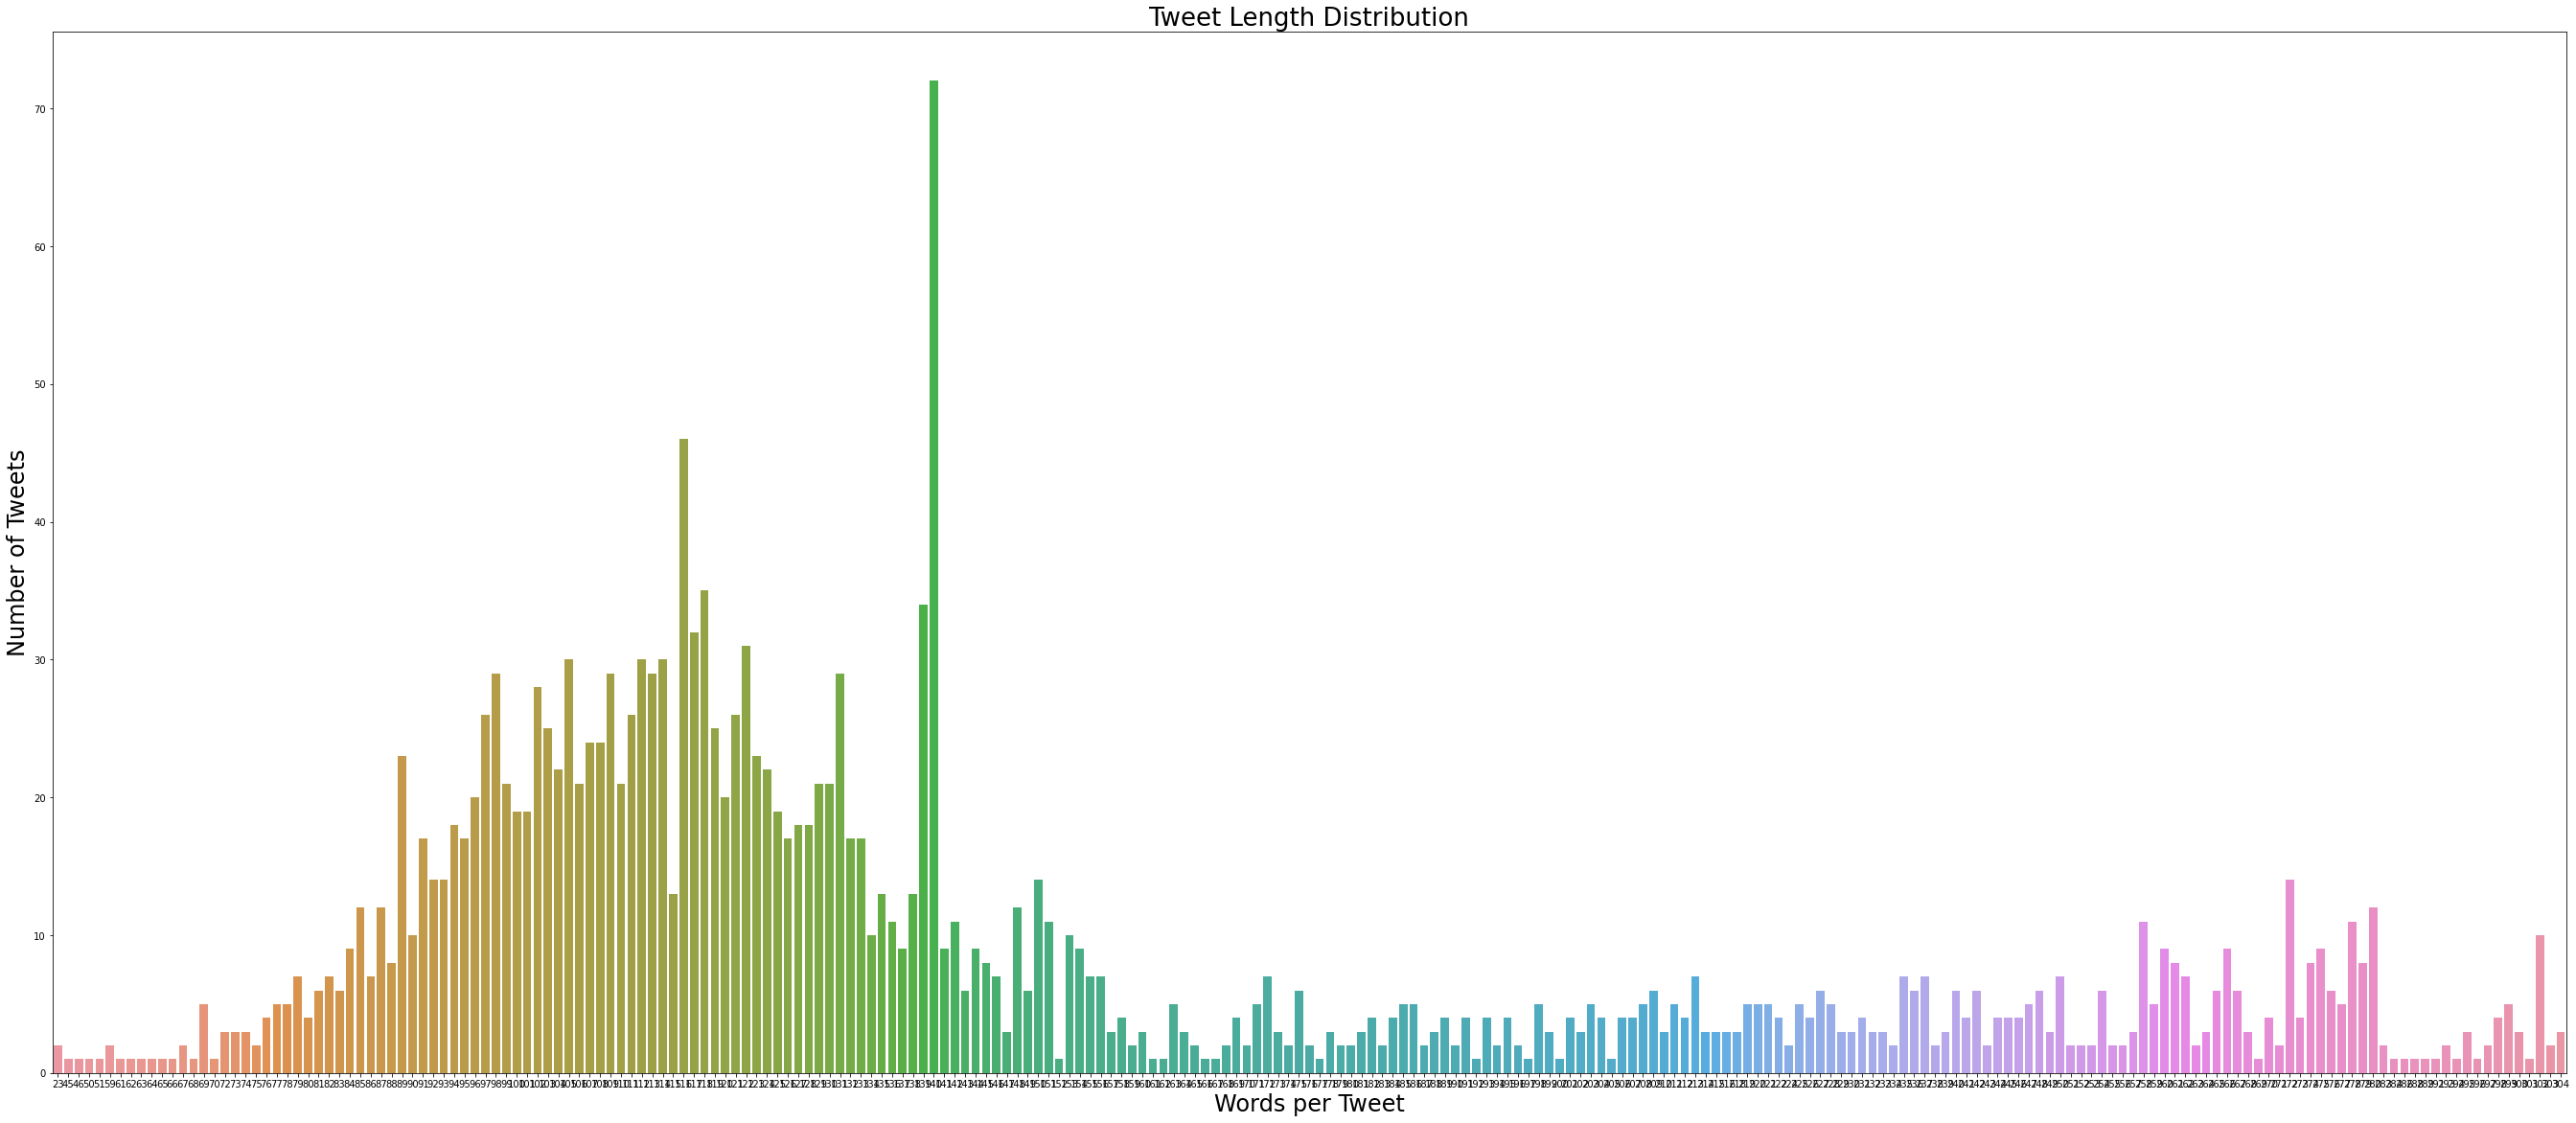

In [16]:
plt.figure(figsize = (47,20))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 26)
plt.xlabel('Words per Tweet', fontsize = 24)
plt.ylabel('Number of Tweets', fontsize = 24)
plt.show()

#### The wordcloud:

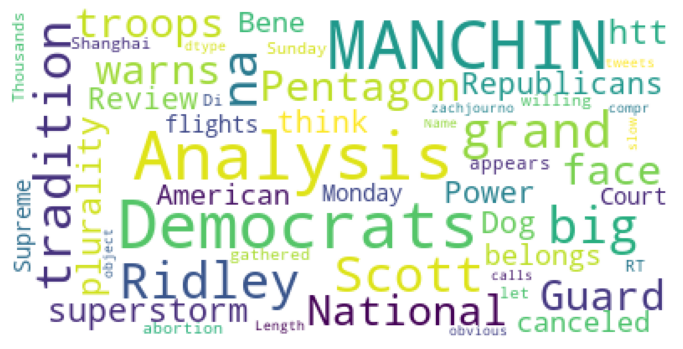

In [17]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
plt.rcParams['figure.figsize']=(12.0,12.0)  
plt.rcParams['font.size']=12            
plt.rcParams['savefig.dpi']=100             
plt.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(new_tweets_df.tweets))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### PyLDAvis

The PyLDAvis library is a great way to visualize topics from a topic model.

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(new_tweets_df.tweets)
data_matrix

<2000x2147 sparse matrix of type '<class 'numpy.int64'>'
	with 18877 stored elements in Compressed Sparse Row format>

In [19]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

In [20]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  21.657503
5       0.648955  71.707100       2        1  12.289551
8      71.019684   9.971006       3        1  12.028965
7       3.785981  33.185135       4        1  11.002494
1     -42.666500  -9.222070       5        1   9.022623
2      -3.621689 -43.526516       6        1   8.869046
4      -3.632402  -4.171708       7        1   8.011434
9     -36.584400  35.804413       8        1   6.763589
0      44.391380  50.615383       9        1   5.404244
3      40.235809 -31.591665      10        1   4.950553, topic_info=           Term        Freq        Total Category  logprob  loglift
1329    opinion  129.000000   129.000000  Default  30.0000  30.0000
2053   virginia   72.000000    72.000000  Default  29.0000  29.0000
2127      world   88.000000    88.000000  Default  28.0000  28.0000
1987      trump   89.000000    89.000000  Default  27.0000  27.0000
94     analysis  127.000000   127.000000  Default  26.0000  26.0000
...         ...         ...          ...      ...      ...      ...
197        best    7.398613    14.724434  Topic10  -4.8609   2.3175
930       https   50.367942  1816.033867  Topic10  -2.9429  -0.5794
836         gov    6.305398    11.933007  Topic10  -5.0208   2.3678
1461  president    7.310859    52.813093  Topic10  -4.8729   1.0283
2140      young    5.653690    15.863298  Topic10  -5.1299   1.9740

[507 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         5  0.295170         000
0         9  0.674675         000
9         7  0.629945        2020
9         9  0.339201        2020
10        7  0.398945        2021
...     ...       ...         ...
2136      8  0.394813       years
2140      1  0.567347       young
2140     10  0.378232       young
2141     10  0.979134    youngkin
2143      6  0.878729  zachjourno

[650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 8, 2, 3, 5, 10, 1, 4])

#### Preprocessing Text Data

Before we can really do anything useful with text data, it must be preprocessed to be a machine readable numeric input. 
Steps are here.
Remove URL’s
Tokenize each tweet
Remove stop words, punctuation, and lowercase all words
Remove any remaining special characters
Lammetization and stemming

#### Removes special charecters,  hyperlinks, punctuations, numbers, emojis, hashtags

In [21]:
def cleaner(tweet):
    # Remove @ sign
    tweet = re.sub("@[A-Za-z0-9]+","",tweet)
    
    # Removes httplinks
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    
    # Remove puncutations
    tweet = re.sub('[()!?]', " ", tweet)
    tweet = re.sub('\[.*?\]',"  ", tweet)
    
    # Join the sub strings generated from re.sub
    tweet = " ".join(tweet.split())
    
    # Remove Emojis
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI)
    
    # Remove hashtag sign and keep the text
    tweet = tweet.replace("#", "").replace("_", " ") 
    
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    
    return tweet

<>:10: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \[
<ipython-input-21-2effe6c3df3f>:10: DeprecationWarning: invalid escape sequence \[
  tweet = re.sub('\[.*?\]',"  ", tweet)


In [22]:
new_tweets_df['cleaned_tweets'] = new_tweets_df['tweets'].map(lambda x: cleaner(x))

In [23]:
new_tweets_df

,tweets,likes,time,cleaned_tweets
0,Ridley Scott and the grand tradition of big-na...,17,2021-11-17 22:47:21,and the grand tradition of big - name disparag...
1,Pentagon warns National Guard troops could be ...,115,2021-11-17 22:32:13,Pentagon National Guard could be forced out fo...
2,Analysis: Democrats face a 2022 superstorm htt...,67,2021-11-17 22:20:57,Analysis : face a 2022
3,Analysis: A plurality of Republicans think the...,51,2021-11-17 22:06:01,Analysis : A plurality of think they ’ re more...
4,Review: “The Power of the Dog” belongs to Bene...,90,2021-11-17 21:51:32,Review : “ The Power of the Dog ” to Benedict ...
...,...,...,...,...
1995,"American canceled about 338 flights Monday, so...",63,2021-11-01 18:56:49,"about 338 , some 6 percent of its for the day ..."
1996,Supreme Court appears willing to let abortion ...,148,2021-11-01 18:51:25,Supreme Court willing to let abortion challeng...
1997,Thousands were gathered Sunday for Shanghai Di...,79,2021-11-01 18:42:28,were for Shanghai ’ s party when suddenly the ...
1998,"RT @zachjourno: MANCHIN: ""It is obvious 'compr...",0,2021-11-01 18:37:15,": : "" It is obvious ' compromise ' is not good..."


In [24]:
data_df = pd.DataFrame({'text':new_tweets_df['cleaned_tweets'], 'index':new_tweets_df.index})

In [25]:
data_df

,text,index
0,and the grand tradition of big - name disparag...,0
1,Pentagon National Guard could be forced out fo...,1
2,Analysis : face a 2022,2
3,Analysis : A plurality of think they ’ re more...,3
4,Review : “ The Power of the Dog ” to Benedict ...,4
...,...,...
1995,"about 338 , some 6 percent of its for the day ...",1995
1996,Supreme Court willing to let abortion challeng...,1996
1997,were for Shanghai ’ s party when suddenly the ...,1997
1998,": : "" It is obvious ' compromise ' is not good...",1998


In [26]:
print(len(data_df))

2000


In [27]:
print(data_df[:5])

                                                text  index
0  and the grand tradition of big - name disparag...      0
1  Pentagon National Guard could be forced out fo...      1
2                             Analysis : face a 2022      2
3  Analysis : A plurality of think they ’ re more...      3
4  Review : “ The Power of the Dog ” to Benedict ...      4


#### Function to perform lemmatize and stem preprocessing steps on the data set.

In [28]:
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [29]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

### Select a document to preview after preprocessing.

In [30]:
doc_sample = data_df[data_df['index'] == 199].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Ford', 'to', 'an', 'inflation', 'crisis', 'with', 'a', 'voluntary', 'public', 'campaign', '.', 'It', 'was', 'a', 'disaster', '.']


 tokenized and lemmatized document: 
['ford', 'inflat', 'crisi', 'voluntari', 'public', 'campaign', 'disast']


### Preprocess the headline text, saving the results as ‘processed_docs’

In [31]:
processed_docs = data_df['text'].map(preprocess)
processed_docs

0                    [grand, tradit, disparag, superhero]
1       [pentagon, nation, guard, forc, vaccin, refus,...
2                                         [analysi, face]
3                  [analysi, plural, think, moder, parti]
4       [review, power, benedict, menac, grief, wester...
                              ...                        
1995                          [percent, roughli, percent]
1996     [suprem, court, will, abort, challeng, procedur]
1997    [shanghai, parti, suddenli, close, health, car...
1998                  [obviou, compromis, good, congress]
1999    [slow, trillion, spend, packag, immin, hous, v...
Name: text, Length: 2000, dtype: object

### Bag of Words on the Data set
Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [39]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 150:
        break

0 disparag
1 grand
2 superhero
3 tradit
4 forc
5 guard
6 mandat
7 nation
8 pentagon
9 refus
10 vaccin
11 analysi
12 face
13 moder
14 parti
15 plural
16 think
17 benedict
18 film
19 grief
20 menac
21 power
22 review
23 western
24 accept
25 accost
26 cortez
27 hous
28 past
29 resolut
30 say
31 will
32 decad
33 natur
34 oversight
35 present
36 time
37 vote
38 jolt
39 life
40 anim
41 censur
42 kill
43 remov
44 video
45 violent
46 account
47 execut
48 hold
49 join
50 media
51 misinform
52 post
53 social
54 appreci
55 chanc
56 curri
57 durant
58 magic
59 blaze
60 burn
61 counti
62 crash
63 engin
64 follow
65 night
66 percent
67 pilot
68 rock
69 singl
70 tanker
71 administr
72 career
73 consum
74 regul
75 reinstat
76 train
77 accus
78 barber
79 color
80 opinion
81 prevent
82 skin
83 trial
84 come
85 eclips
86 lunar
87 partial
88 agenda
89 balanc
90 climat
91 electr
92 infrastructur
93 packag
94 presid
95 promot
96 rest
97 travel
98 case
99 deliber
100 homicid
101 kyle
102 live
103 better
104 

Filter out tokens that appear in
less than 15 documents (absolute number) or
more than 0.5 documents (fraction of total corpus size, not absolute number).
after the above two steps, keep only the first 100000 most frequent tokens.

In [40]:
dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=100000)

#### Gensim doc2bow
For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.

In [41]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[99]

[(80, 1), (491, 1), (492, 1), (493, 1)]

#### Preview Bag Of Words for our sample preprocessed document.

In [42]:
bow_doc_99 = bow_corpus[99]
for i in range(len(bow_doc_99)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_99[i][0], 
                                               dictionary[bow_doc_99[i][0]], 
bow_doc_99[i][1]))

Word 80 ("opinion") appears 1 time.
Word 491 ("molli") appears 1 time.
Word 492 ("musk") appears 1 time.
Word 493 ("stop") appears 1 time.


### TF-IDF

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [43]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5728103618453128),
 (1, 0.4377818707718831),
 (2, 0.49001802160028357),
 (3, 0.49001802160028357)]


### Running LDA using Bag of Words

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [45]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

For each topic, we will explore the words occuring in that topic and its relative weight.

In [46]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"climat" + 0.009*"citi" + 0.007*"world" + 0.007*"nation" + 0.006*"go" + 0.006*"hous" + 0.006*"opinion" + 0.005*"deal" + 0.005*"analysi" + 0.005*"vote"
Topic: 1 
Words: 0.023*"opinion" + 0.016*"post" + 0.012*"live" + 0.008*"year" + 0.008*"trump" + 0.008*"climat" + 0.007*"covid" + 0.006*"hous" + 0.006*"presid" + 0.005*"nation"
Topic: 2 
Words: 0.016*"trump" + 0.015*"world" + 0.009*"analysi" + 0.007*"governor" + 0.007*"peopl" + 0.007*"rise" + 0.007*"investig" + 0.006*"republican" + 0.006*"week" + 0.006*"race"
Topic: 3 
Words: 0.012*"elect" + 0.010*"world" + 0.009*"climat" + 0.008*"race" + 0.007*"post" + 0.007*"summit" + 0.007*"opinion" + 0.006*"percent" + 0.006*"analysi" + 0.006*"warm"
Topic: 4 
Words: 0.017*"analysi" + 0.012*"elect" + 0.008*"percent" + 0.007*"climat" + 0.007*"infrastructur" + 0.007*"feder" + 0.007*"presid" + 0.006*"time" + 0.006*"colleg" + 0.005*"peopl"
Topic: 5 
Words: 0.013*"climat" + 0.012*"hous" + 0.010*"presid" + 0.008*"turn" + 0.008*"trump" +

#### Performance evaluation using LDA Bag of Words model

In [47]:
processed_docs[99]

['opinion', 'molli', 'musk', 'stop']

In [48]:
for index, score in sorted(lda_model[bow_corpus[25]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9099758267402649	 
Topic: 0.011*"trial" + 0.010*"peopl" + 0.008*"perspect" + 0.006*"kyle" + 0.006*"million" + 0.006*"court" + 0.006*"help" + 0.006*"world" + 0.006*"trump" + 0.005*"say"

Score: 0.01000475138425827	 
Topic: 0.017*"analysi" + 0.012*"elect" + 0.008*"percent" + 0.007*"climat" + 0.007*"infrastructur" + 0.007*"feder" + 0.007*"presid" + 0.006*"time" + 0.006*"colleg" + 0.005*"peopl"

Score: 0.010003781877458096	 
Topic: 0.016*"trump" + 0.015*"world" + 0.009*"analysi" + 0.007*"governor" + 0.007*"peopl" + 0.007*"rise" + 0.007*"investig" + 0.006*"republican" + 0.006*"week" + 0.006*"race"

Score: 0.010002769529819489	 
Topic: 0.010*"analysi" + 0.009*"opinion" + 0.007*"presid" + 0.007*"perspect" + 0.006*"like" + 0.005*"intern" + 0.005*"work" + 0.005*"white" + 0.004*"feder" + 0.004*"million"

Score: 0.010002527385950089	 
Topic: 0.012*"elect" + 0.010*"world" + 0.009*"climat" + 0.008*"race" + 0.007*"post" + 0.007*"summit" + 0.007*"opinion" + 0.006*"percent" + 0.006*"analysi"

### Running LDA using TF-IDF

In [49]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"week" + 0.005*"analysi" + 0.005*"elect" + 0.004*"watch" + 0.004*"homicid" + 0.004*"climat" + 0.003*"enforc" + 0.003*"live" + 0.003*"global" + 0.003*"night"
Topic: 1 Word: 0.005*"year" + 0.005*"analysi" + 0.005*"climat" + 0.004*"perspect" + 0.003*"best" + 0.003*"elect" + 0.003*"mayor" + 0.003*"border" + 0.003*"world" + 0.003*"summit"
Topic: 2 Word: 0.006*"world" + 0.005*"covid" + 0.004*"debat" + 0.004*"travel" + 0.004*"year" + 0.004*"peopl" + 0.004*"vaccin" + 0.003*"opinion" + 0.003*"free" + 0.003*"know"
Topic: 3 Word: 0.005*"return" + 0.004*"analysi" + 0.004*"presid" + 0.004*"million" + 0.004*"like" + 0.004*"jail" + 0.003*"perspect" + 0.003*"vote" + 0.003*"rise" + 0.003*"hous"
Topic: 4 Word: 0.004*"chang" + 0.004*"climat" + 0.004*"vaccin" + 0.003*"analysi" + 0.003*"social" + 0.003*"trump" + 0.003*"campaign" + 0.003*"perspect" + 0.003*"report" + 0.003*"live"
Topic: 5 Word: 0.006*"trump" + 0.006*"analysi" + 0.005*"post" + 0.005*"come" + 0.004*"live" + 0.004*"home" +

#### Performance evaluation by classifying sample document using LDA TF-IDF model.

In [52]:
for index, score in sorted(lda_model_tfidf[bow_corpus[25]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.7423949837684631	 
Topic: 0.004*"chang" + 0.004*"climat" + 0.004*"vaccin" + 0.003*"analysi" + 0.003*"social" + 0.003*"trump" + 0.003*"campaign" + 0.003*"perspect" + 0.003*"report" + 0.003*"live"

Score: 0.17753595113754272	 
Topic: 0.005*"vaccin" + 0.005*"analysi" + 0.005*"judg" + 0.004*"covid" + 0.004*"world" + 0.004*"know" + 0.004*"school" + 0.004*"post" + 0.004*"need" + 0.003*"turn"

Score: 0.010010667145252228	 
Topic: 0.008*"opinion" + 0.007*"governor" + 0.006*"climat" + 0.005*"race" + 0.004*"remain" + 0.004*"live" + 0.004*"percent" + 0.003*"analysi" + 0.003*"vaccin" + 0.003*"chang"

Score: 0.010009725578129292	 
Topic: 0.005*"year" + 0.005*"analysi" + 0.005*"climat" + 0.004*"perspect" + 0.003*"best" + 0.003*"elect" + 0.003*"mayor" + 0.003*"border" + 0.003*"world" + 0.003*"summit"

Score: 0.010009105317294598	 
Topic: 0.006*"world" + 0.005*"covid" + 0.004*"debat" + 0.004*"travel" + 0.004*"year" + 0.004*"peopl" + 0.004*"vaccin" + 0.003*"opinion" + 0.003*"free" + 0.003*"kn

### Testing model on unseen document

In [53]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.48657259345054626	 Topic: 0.010*"climat" + 0.009*"citi" + 0.007*"world" + 0.007*"nation" + 0.006*"go"
Score: 0.3533414602279663	 Topic: 0.011*"trial" + 0.010*"peopl" + 0.008*"perspect" + 0.006*"kyle" + 0.006*"million"
Score: 0.02001335471868515	 Topic: 0.022*"analysi" + 0.013*"climat" + 0.010*"perspect" + 0.008*"chang" + 0.008*"help"
Score: 0.02001306042075157	 Topic: 0.016*"trump" + 0.015*"world" + 0.009*"analysi" + 0.007*"governor" + 0.007*"peopl"
Score: 0.020012782886624336	 Topic: 0.018*"year" + 0.013*"opinion" + 0.011*"analysi" + 0.010*"vaccin" + 0.008*"post"
Score: 0.020011328160762787	 Topic: 0.010*"analysi" + 0.009*"opinion" + 0.007*"presid" + 0.007*"perspect" + 0.006*"like"
Score: 0.0200100839138031	 Topic: 0.013*"climat" + 0.012*"hous" + 0.010*"presid" + 0.008*"turn" + 0.008*"trump"
Score: 0.020009750500321388	 Topic: 0.017*"analysi" + 0.012*"elect" + 0.008*"percent" + 0.007*"climat" + 0.007*"infrastructur"
Score: 0.02000841125845909	 Topic: 0.012*"elect" + 0.010*"wo

#### Word Cloud

In [54]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
import matplotlib.pyplot as plt
%matplotlib inline

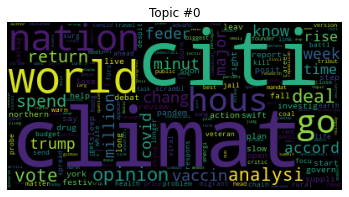

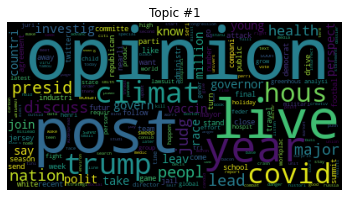

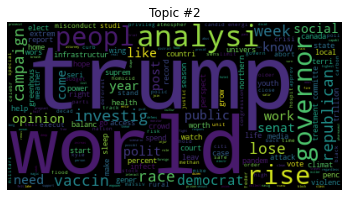

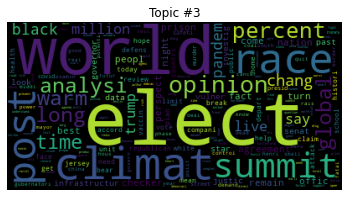

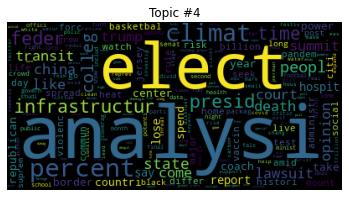

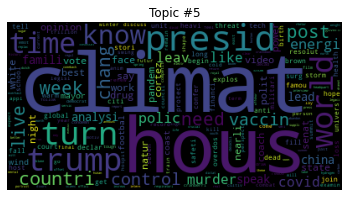

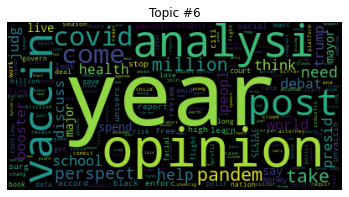

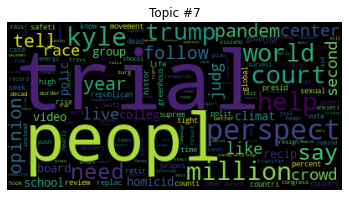

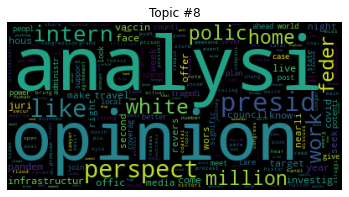

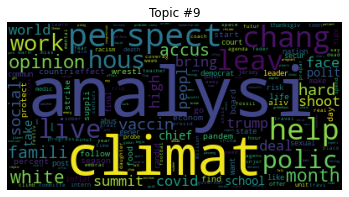

In [55]:
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [56]:
kl = []
for t in range(lda_model.num_topics):
    kl.extend(list(dict(lda_model.show_topic(t)).keys()))
    
pprint(kl)

['climat',
 'citi',
 'world',
 'nation',
 'go',
 'hous',
 'opinion',
 'deal',
 'analysi',
 'vote',
 'opinion',
 'post',
 'live',
 'year',
 'trump',
 'climat',
 'covid',
 'hous',
 'presid',
 'nation',
 'trump',
 'world',
 'analysi',
 'governor',
 'peopl',
 'rise',
 'investig',
 'republican',
 'week',
 'race',
 'elect',
 'world',
 'climat',
 'race',
 'post',
 'summit',
 'opinion',
 'percent',
 'analysi',
 'warm',
 'analysi',
 'elect',
 'percent',
 'climat',
 'infrastructur',
 'feder',
 'presid',
 'time',
 'colleg',
 'peopl',
 'climat',
 'hous',
 'presid',
 'turn',
 'trump',
 'world',
 'time',
 'know',
 'countri',
 'post',
 'year',
 'opinion',
 'analysi',
 'vaccin',
 'post',
 'covid',
 'come',
 'pandem',
 'take',
 'million',
 'trial',
 'peopl',
 'perspect',
 'kyle',
 'million',
 'court',
 'help',
 'world',
 'trump',
 'say',
 'analysi',
 'opinion',
 'presid',
 'perspect',
 'like',
 'intern',
 'work',
 'white',
 'feder',
 'million',
 'analysi',
 'climat',
 'perspect',
 'chang',
 'help',
 'l

In [57]:
kl_df = pd.DataFrame({'words':kl})

#### A Bar Diagram showing the top-5 topics for any Twitter handler of your choice

In [58]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [59]:
topics_list = []
score_list = []
for t in range(lda_model.num_topics):
    d = dict(lda_model.show_topic(t))
    topics_list.append(list(d)[0])
    score_list.append(d[list(d)[0]])
    
topic_score_df = pd.DataFrame({"labels":topics_list, "score": score_list})
print(topic_score_df)

       labels     score
0     percent  0.009850
1     analysi  0.014760
2      climat  0.026865
3       trump  0.014048
4     analysi  0.016912
5       elect  0.012702
6     opinion  0.029040
7  republican  0.016827
8      climat  0.010522
9    governor  0.017608


In [60]:
top_five = topic_score_df.sort_values(by='score', ascending=False).head(5)

In [61]:
top_five

,labels,score
6,opinion,0.029040
2,climat,0.026865
9,governor,0.017608
4,analysi,0.016912
7,republican,0.016827


In [62]:
def TopicsBarChart(labels, score, title):
    color = ['BLUE', 'SILVER', 'GREEN', 'GOLD', 'ORANGE']
    f = plt.figure(figsize =(14, 5) )

    ax = plt.subplot(111) 
    count = 0
    index = [1,2,3,4,5]
    
    graph = ax.bar(index, score, label = labels, color = color)
    
    ax=plt.gca()

    ax.set_ylabel("Topics", fontsize=18, labelpad=5, color='black')
    ax.set_xlabel("Topics Score", fontsize=18, labelpad=5, color='black')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.title(title, fontsize=14)

    ax.legend(graph, labels, loc="center",
              frameon=False, bbox_to_anchor=(0.5, -0.3))

    plt.show()

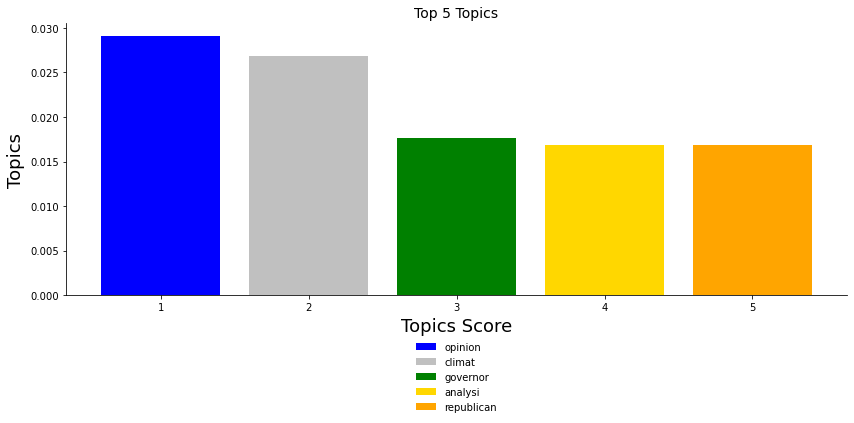

In [65]:
TopicsBarChart(top_five['labels'], top_five['score'], 'Top 5 Topics')

### Please enter a word to display the related tweets for that word

In [66]:
pd.set_option("display.max_colwidth", None)
def get_tweets(input):  
    print("The Washington Post, @washingtonpost")
    print("Washington, DC")
    fetched_tweets = data_df[data_df['text'].str.contains(input)]
    fetched_tweets = fetched_tweets["text"]
    fetched_tweets.reset_index(drop=True, inplace=True)
    return fetched_tweets

In [68]:
user_input = input("Please enter a word to display the related tweets for that word:")
get_tweets(user_input)

Please enter a word to display the related tweets for that word:Power
The Washington Post, @washingtonpost
Washington, DC


0    Review : “ The Power of the Dog ” to Benedict , who menace and grief to the western film
Name: text, dtype: object

In [67]:
data_df

,text,index
0,and the grand tradition of big - name disparaging superhero,0
1,Pentagon National Guard could be forced out for vaccine refusal after mandate,1
2,Analysis : face a 2022,2
3,Analysis : A plurality of think they ’ re more moderate than their party,3
4,"Review : “ The Power of the Dog ” to Benedict , who menace and grief to the western film",4
...,...,...
1995,"about 338 , some 6 percent of its for the day , to 1 , 060 — or roughly 20 percent — on . Between and , the about 1 , 900 .",1995
1996,Supreme Court willing to let abortion challenge a law that mostly the procedure there,1996
1997,were for Shanghai ’ s party when suddenly the closed and health - care fully dressed in white protective on the site .,1997
1998,": : "" It is obvious ' compromise ' is not good enough for a lot of my in Congress . It ' s all or nothing and the …",1998
